\newpage

1. Using the UCI heart disease dataset, the project is trying to develop a predictive classification model to determine whether a patient has a heart problem based on 13 medical and demographical features. The response variable num, originally ranges from 0 to 4, is conveted to a binary variable that indicates the heart disease's presense. 0 represents no heart disease, and 1 (combining 1-4) represents its presense. Thus this project becomes a binary classification probelm with the objective of accurately predict the presense of heart disease.

In [11]:
#Load necessary libraries
!pip install matplotlib
!pip install seaborn

from ucimlrepo import fetch_ucirepo 
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [12]:
# fetch dataset 
heart_disease = fetch_ucirepo(id=45) 

df = pd.concat([heart_disease.data.features, heart_disease.data.targets], axis=1)

2. We applied one-hot encoding to all categorical variables to convert them into numerical form. Numerical features are standardized using z-score normalization. These transformations ensure that all input features are on the comparable scale, this is critically important to algorithms that are sensitive to feature magnitude. 

In [13]:
#2

categorical_cols = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca', 'thal']
numerical_cols = [col for col in df.columns if col not in categorical_cols + ['num']]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
scaler = StandardScaler()
df[numerical_cols] = scaler.fit_transform(df[numerical_cols])

Number of observations (rows): 303
Number of variables (columns): 21

Variable names and data types:
age          float64
trestbps     float64
chol         float64
thalach      float64
oldpeak      float64
num            int64
sex_1           bool
cp_2            bool
cp_3            bool
cp_4            bool
fbs_1           bool
restecg_1       bool
restecg_2       bool
exang_1         bool
slope_2         bool
slope_3         bool
ca_1.0          bool
ca_2.0          bool
ca_3.0          bool
thal_6.0        bool
thal_7.0        bool
dtype: object

Missing values:
age          0
trestbps     0
chol         0
thalach      0
oldpeak      0
num          0
sex_1        0
cp_2         0
cp_3         0
cp_4         0
fbs_1        0
restecg_1    0
restecg_2    0
exang_1      0
slope_2      0
slope_3      0
ca_1.0       0
ca_2.0       0
ca_3.0       0
thal_6.0     0
thal_7.0     0
dtype: int64

Descriptive statistics:
                age      trestbps          chol       thalach       oldpea

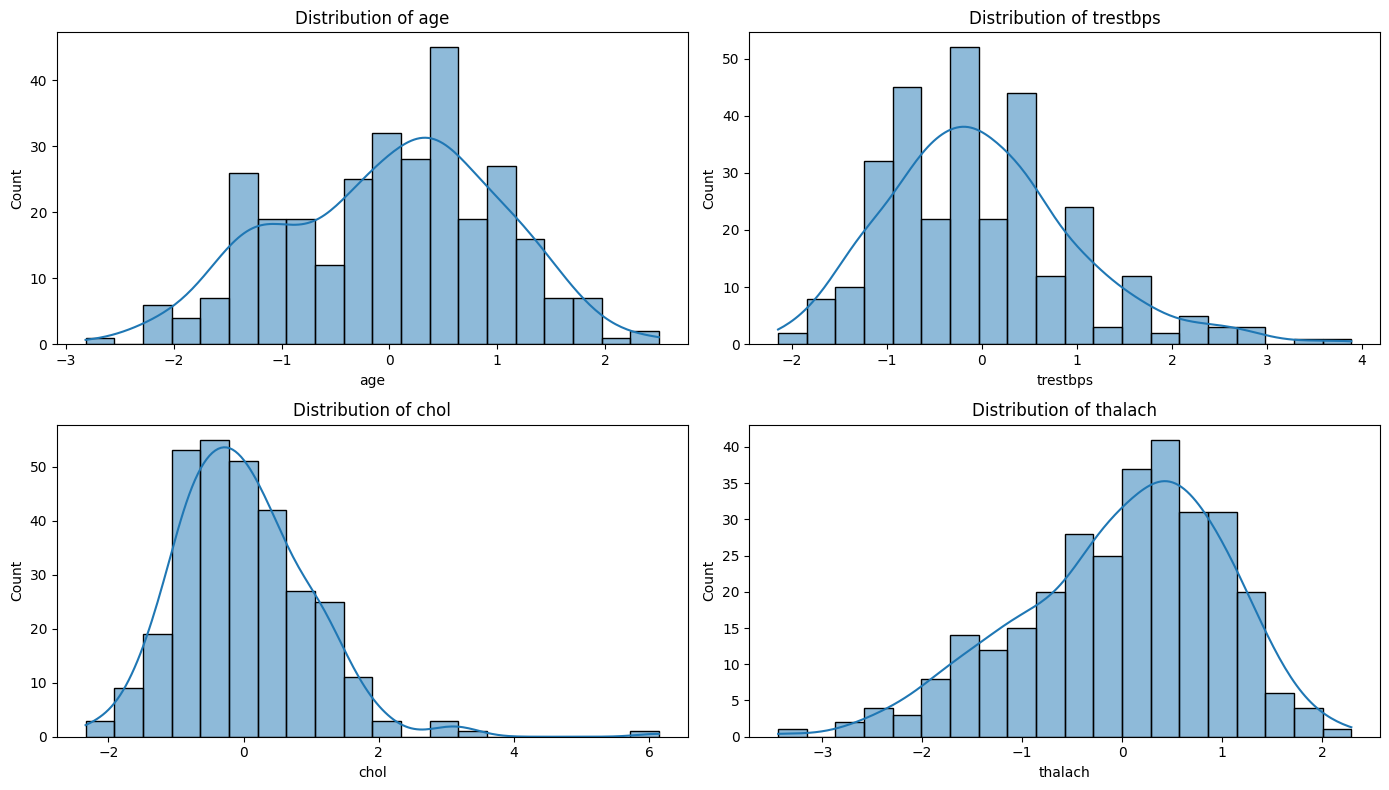

In [14]:
#3
print("Number of observations (rows):", df.shape[0])
print("Number of variables (columns):", df.shape[1])

print("\nVariable names and data types:")
print(df.dtypes)

print("\nMissing values:")
print(df.isnull().sum())

print("\nDescriptive statistics:")
print(df.describe())

plt.figure(figsize=(14, 8))
vars_to_plot = ['age', 'trestbps', 'chol', 'thalach']
for i, var in enumerate(vars_to_plot, 1):
    plt.subplot(2, 2, i)
    sns.histplot(df[var].dropna(), kde=True, bins=20)
    plt.title(f'Distribution of {var}')
plt.tight_layout()
plt.show()

The dataset has 303 observations and 14 variables.

Although all 14 variables are stored as `float64` due to the OpenML, not all of them are actually numerical in nature. Some of them just use numbers to represent different categories.
For example:
- Categorical variables: `sex`, `cp`, `fbs`, `restecg`, `exang`, `slope`, `ca`, `thal`, and `target`.  They are better understood as categorical, represent different groups or types rather than continuous values.
- Numerical variables: `age`, `trestbps`, `chol`, `thalach`, and `oldpeak` 
- The target variable (target) is binary:
1 indicates presence of heart disease, 0 indicates absence.
##### Observation：
- 1.There are no missing values in the dataset, so it can be used directly for modeling without any imputation.
- 2.The average patient age is around 54 years, with most patients between 40 and 65.
- 3.The cholesterol and resting blood pressure (trestbps) variables appear to be right-skewed, based on their histograms.

In [18]:
#4
df['target'] = df['num'].apply(lambda x: 1 if x > 0 else 0)
df.drop(columns='num', inplace=True)

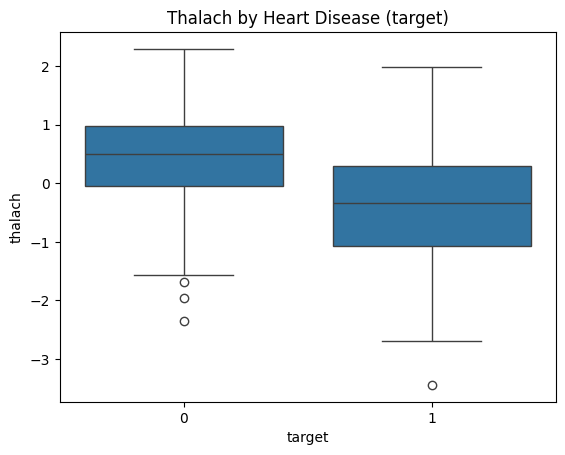

{'cp_2': np.float64(0.18), 'cp_3': np.float64(0.21), 'cp_4': np.float64(0.73)}


In [25]:
#5
import seaborn as sns
import matplotlib.pyplot as plt

# boxplot
sns.boxplot(data=df, x='target', y='thalach')
plt.title("Thalach by Heart Disease (target)")
plt.show()

# Groupby analysis: average heart disease rate by chest pain type
cp_target_means = {}

for col in ['cp_2', 'cp_3', 'cp_4']:
    mean_val = df[df[col] == 1]['target'].mean()
    cp_target_means[col] = round(mean_val, 2)  

print(cp_target_means)



##### Statement：
- Patients without heart disease (target = 0) tend to have higher maximum heart rates, while those with heart disease (target = 1) have lower values on average.
- We find that patients with `cp_4 = 1` have a much higher likelihood of having heart disease compared to those with other chest pain types. Therefore, chest pain type is a valuable predictor and should be retained as a feature during model training.

In [26]:
#6
df_dropped = df.dropna()
print("Number of observations after dropping rows with missing values:", df_dropped.shape[0])


Number of observations after dropping rows with missing values: 303
